# Graph Summarization
OpenSeaDragon works by starting with one large image, then computing a zoomstack of images where each layer of the stack is a 2x reduction.  
`32x 16x 8x 4x 2x 1x`

This means that regardless of the size of the image and the zoom level, the server always communicates the same number of bytes to the client.  Everything is precomputed.  VG has chunks which can be thought of a groups of nodes along a linear genome, this allows streaming of a local context.  We’ll call this graph the “true graph”.  We compute a series of zoom layers - each takes two chunks from the previous layer and summarizes it into one chunk with half as many nodes, maintaining roughly the same number of bytes.  Two chunks of this Summary Layer 1 is then used to compute one chunk of Summary Layer 2, and so on.

The challenge is then reframed to what features to eliminate when summarizing a given graph chunk.  Summarization paths will have one additional metadata field for each node: % identity is the summed error between the visualized summary and actual sequence.  Gaps or SNPs that get collapsed into a single node will lower the % identity for a particular path.  Haplotypes should be preserved as much as possible by merging multiple diagnostic SNPs into one larger node (see “split vertical”).  The required eliminations are based on a **maximum number of nodes per view window** meaning that sparse regions can remain unaltered.  
Eliminations are prioritized by the number of nucleotides multiplied by the number of accessions (N * A) involved.  Summarization will take the next move that minimizes the loss of N * A until the target number of nodes is reached:



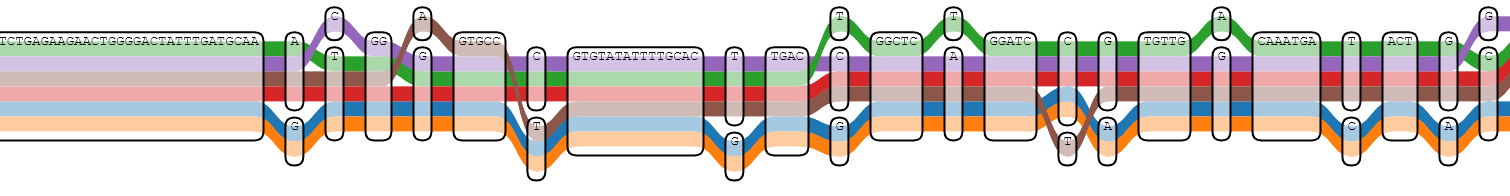

## Prototype Representation
Any graph can be linearized in a predictable order.  Here we'll assume that the graph has been linearized, the graph is now an ordered list.  Each element is a vertical slice containing the possible alternative nodes (e.g. SNPs) at each position.  For the prototype, nodes are a sets of paths.  If a path is listed in a node, it means the path goes through that node, otherwise it skips it.  
`Graph[  Slice[ Node{1,3,4}, Node{2} ], Slice[ Node{1,2,3,4}] ]`  
`GraphSummary1[ Slice[ Node{1,2,3,4} ] ]    ` or ` GraphSummary1[ Slice[ Node{1,3,4}, Node{2} ] ]`  
**Assumptions**:  
* Paths can't be listed in both alternative nodes at the same time.  
    * Could have "Absent node" listed for set intersection convenience.
* If a path isn't mentioned in a slice it has a "deletion" at that position.  
* At nucleotide level, there are only 4 possible slices.  But this becomes unbounded when combining and making kmers.



In [9]:
import unittest 
test = unittest.TestCase()  # just using it for assertRaises
from typing import Callable, Iterator, Union, Optional, List, Iterable
from collections import namedtuple
from itertools import zip_longest
# %debug

In [33]:
#Node = namedtuple('Node', ['seq', 'paths'])
class Node:
    def __init__(self, seq: str, paths: Iterable[int]):
        assert isinstance(seq, str), seq
        assert not isinstance(paths, str) and isinstance(paths, Iterable), paths
        self.seq = seq
        self.paths = set(paths)
    def __len__(self):
        return len(self.paths)
    def __repr__(self):
        """Paths representation is sorted because set ordering is not guaranteed."""
        return repr(self.seq) + \
        ', {' + ', '.join(str(i) for i in sorted(list(self.paths))) + '}' 
    def __eq__(self, other):
        if not isinstance(other, Node):
            print("Warn: comparing Node and ", type(other), other)
            return False
        return self.seq == other.seq and self.paths == other.paths
    def __hash__(self):
        return hash(self.seq)
    

def merge(self, smaller: Node) -> Node:
    m = Node(self.seq, self.paths.union(smaller.paths))
    # TODO: penalize paths with nucleotide mismatch
    return m
Node.merge = merge

        
class Slice:
    def __init__(self, nodes: Iterable[Node]):
        self.nodes = set(nodes) 
    def alternatives(self, main):
        return self.nodes.difference({main})
    def bystanders(self, first,second):
        return self.nodes.difference({first,second})
    def __len__(self):
        return len(self.nodes)
    def __repr__(self):
        #return '{' + ', '.join(str(i) for i in sorted(list(self.nodes))) + '}' 
        return list(self.nodes).__repr__()# '['+ ','.join(self.paths)+']'
    def __eq__(self, other):
        if isinstance(other, Slice):
            #all(a==b for a,b in zip_longest(self.nodes,other.nodes)) # order dependent
            if not self.nodes == other.nodes:
                print(self.nodes, other.nodes, sep='\n')
            return self.nodes == other.nodes
        else:
            print("Warn: comparing Slice and ", type(other), other)
            return False
    
    def primary(self):
        return max(self.nodes, key=len)  # When they're the same size, take the other
    def secondary(self):
        biggest = self.primary()
        return max((x for x in self.nodes if x != biggest), key=len)  # When they're the same size, take the next one
    def smallest(self):
        return min(reversed(self.nodes), key=len)  # when they're the same size it will take the last listed

class Graph:
    def __init__(self, cmd: List):
        """Factory for generating graphs from a representation"""
        self.slices = []
        if cmd[0] and isinstance(next(iter(cmd[0])), Node):
            self.slices = cmd  # doesn't need to be parsed
        else:
            if isinstance(cmd, str):
                cmd = eval(cmd)
            #print('c', cmd)
            for sl in cmd:
                current_slice = []
                try:
                    for i in range(0, len(sl), 2):
                        current_slice.append(Node(sl[i], sl[i+1]))
                except IndexError:
                    print("Expecting two terms: ", sl[i:i+2])
                self.slices.append(Slice(current_slice))
            
    def __repr__(self):
        """Warning: the representation strings are very sensitive to whitespace"""
        return self.slices.__repr__()
    def __getitem__(self, i):
        return self.slices[i]
    def __eq__(self, representation):
        if isinstance(representation, Graph):
            return all(slice_a == slice_b for slice_a, slice_b in zip_longest(self.slices, representation.slices))
        return self == Graph(representation)  # build a graph then compare it
            
            
            
#base_graph = [ [{1,2,3,4}], [{1,2,4},{3}],  [{1,2,3,4}],  [{1,2,4},{3}],  [{1,2,3},{4}],  [{1,2,3,4}] ]
factory_input = [['ACGT',{1,2,3,4}], ['C',{1,2,4},'T',{3}],  ['GGA',{1,2,3,4}],  
              ['C',{1,2,4},'',{3}],  ['AGTACG',{1,2,3},'CGTACT',{4}],  ['TTG',{1,2,3,4}] ]
base_graph = [Slice([Node('ACGT', {1,2,3,4})]), 
              Slice([Node('C',{1,2,4}),Node('T', {3})]),  
              Slice([Node('GGA',{1,2,3,4})]),  
              Slice([Node('C',{1,2,4}),Node('', {3})]),
              Slice([Node('AGTACG',{1,2,3}), Node('CGTACT',{4})]),
              Slice([Node('TTG',{1,2,3,4})]) ]

g = Graph(factory_input)
g
assert g == str(factory_input), ('\n' + repr(g) + '\n' + str(factory_input))
g_double = Graph(eval(str(g)))
str(g_double) == str(g)  # WARN: could be order sensitive, don't worry if it fails
assert g_double == g
assert g_double == factory_input
assert g_double == str(factory_input)

**Developers Note**: If you need sets with preserved ordering use Python 3.6 dictionaries instead of sets: `dict.fromkeys([67, 46, 55, 39, 94, 63, 34, 32, 57, 54, 67, 36, 63]).keys()`

### Merge Vertical  
Listed first because it's Simple:  
Alternative alleles are merged into a single node. Node gets N*A % identity penalized.
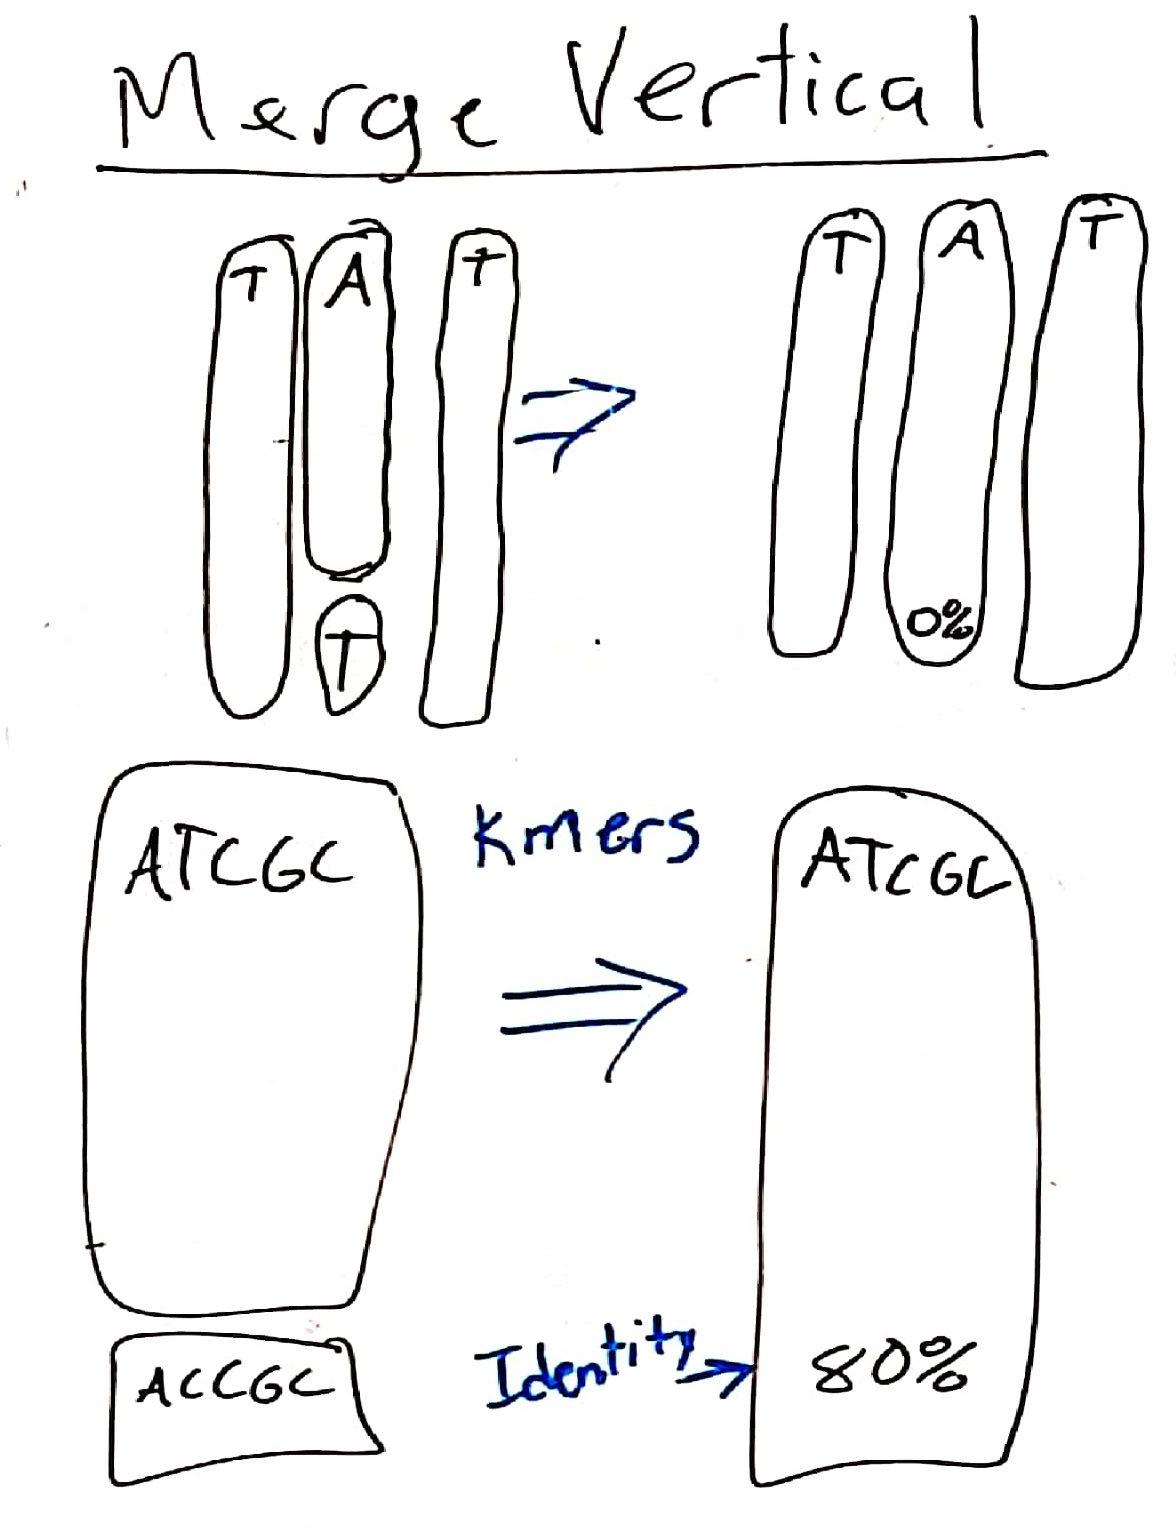

In [ ]:
def merge_vertical(one_slice: Slice) -> List[Slice]:
    """Merges the smallest node into the biggest node.  Preserves bystander nodes as well."""
    assert len(one_slice) > 1
    smallest_node = one_slice.smallest()
    biggest_node = one_slice.primary()
    merger = biggest_node.merge(smallest_node)
    if len(one_slice) == 2: 
        return Graph([[merger]])
    else:  #Allows for third possibilities
        return Graph([[merger, *one_slice.bystanders(smallest_node, biggest_node)]])
assert merge_vertical(base_graph[1]) == [['C', {1, 2, 3, 4}]]
merge_vertical(Graph([['A',{1,2,4}, 'C',{3}, 'T',{12,16}]])[0])
# assert merge_vertical([{1,2,4}, {3}, {12,16}]) == [[{1, 2, 3, 4}, {12, 16}]]
# assert merge_vertical([{1, 2}, {3, 4}]) == [[{1, 2, 3, 4}]]

In [ ]:
base_graph[1], type(base_graph[1])

In [ ]:
#TODO: is this operate on one slice or three???
def merge_vertical_threesome(anchor_left, target_slice, anchor_right):
    """Merges three slices together by dropping out the one variant node that is holding them apart.  
    Requires the surrounding anchor nodes to 100% match.  Returns new subgraph."""
    merged = merge_vertical(target_slice)[0]  # [0] selects the only slice present
    if len(merged) > 1:  # check to ensure there was not a third option
        return [anchor_left, merged, anchor_right]  # we were not able to collapse the threesome
    elif anchor_left == anchor_right: # TODO: set equality, not same objects
        if anchor_left == merged:
            return [anchor_left]  # all three are equivalent so you can just return one.
            #TODO: include sequence penalties
    raise ValueError("All three sets must be equal in order to collapse the slices")
assert merge_vertical_threesome(*base_graph[0:3]) == [[{1, 2, 3, 4}]]
with test.assertRaises(ValueError):
    merge_vertical_threesome(*base_graph[1:4])
with test.assertRaises(ValueError):
    merge_vertical_threesome([{1,2,3,4}], [{1,2,4},{3}],  [{1}])

### Split Vertical 
If N+2 nodes position shares our haplotype to within %, split out haplotype from N+1 node and combine N, new N+1, and N+2 into a single node with a joint kmer (see Graph Summarization - Worked Example).
* This prevents conserved sequence nodes from stopping haplotype propagation.
* As conserved spacing nodes get merged, our power to detect an N+2 haplotype match increases.  We can skip more than one nucleotide.


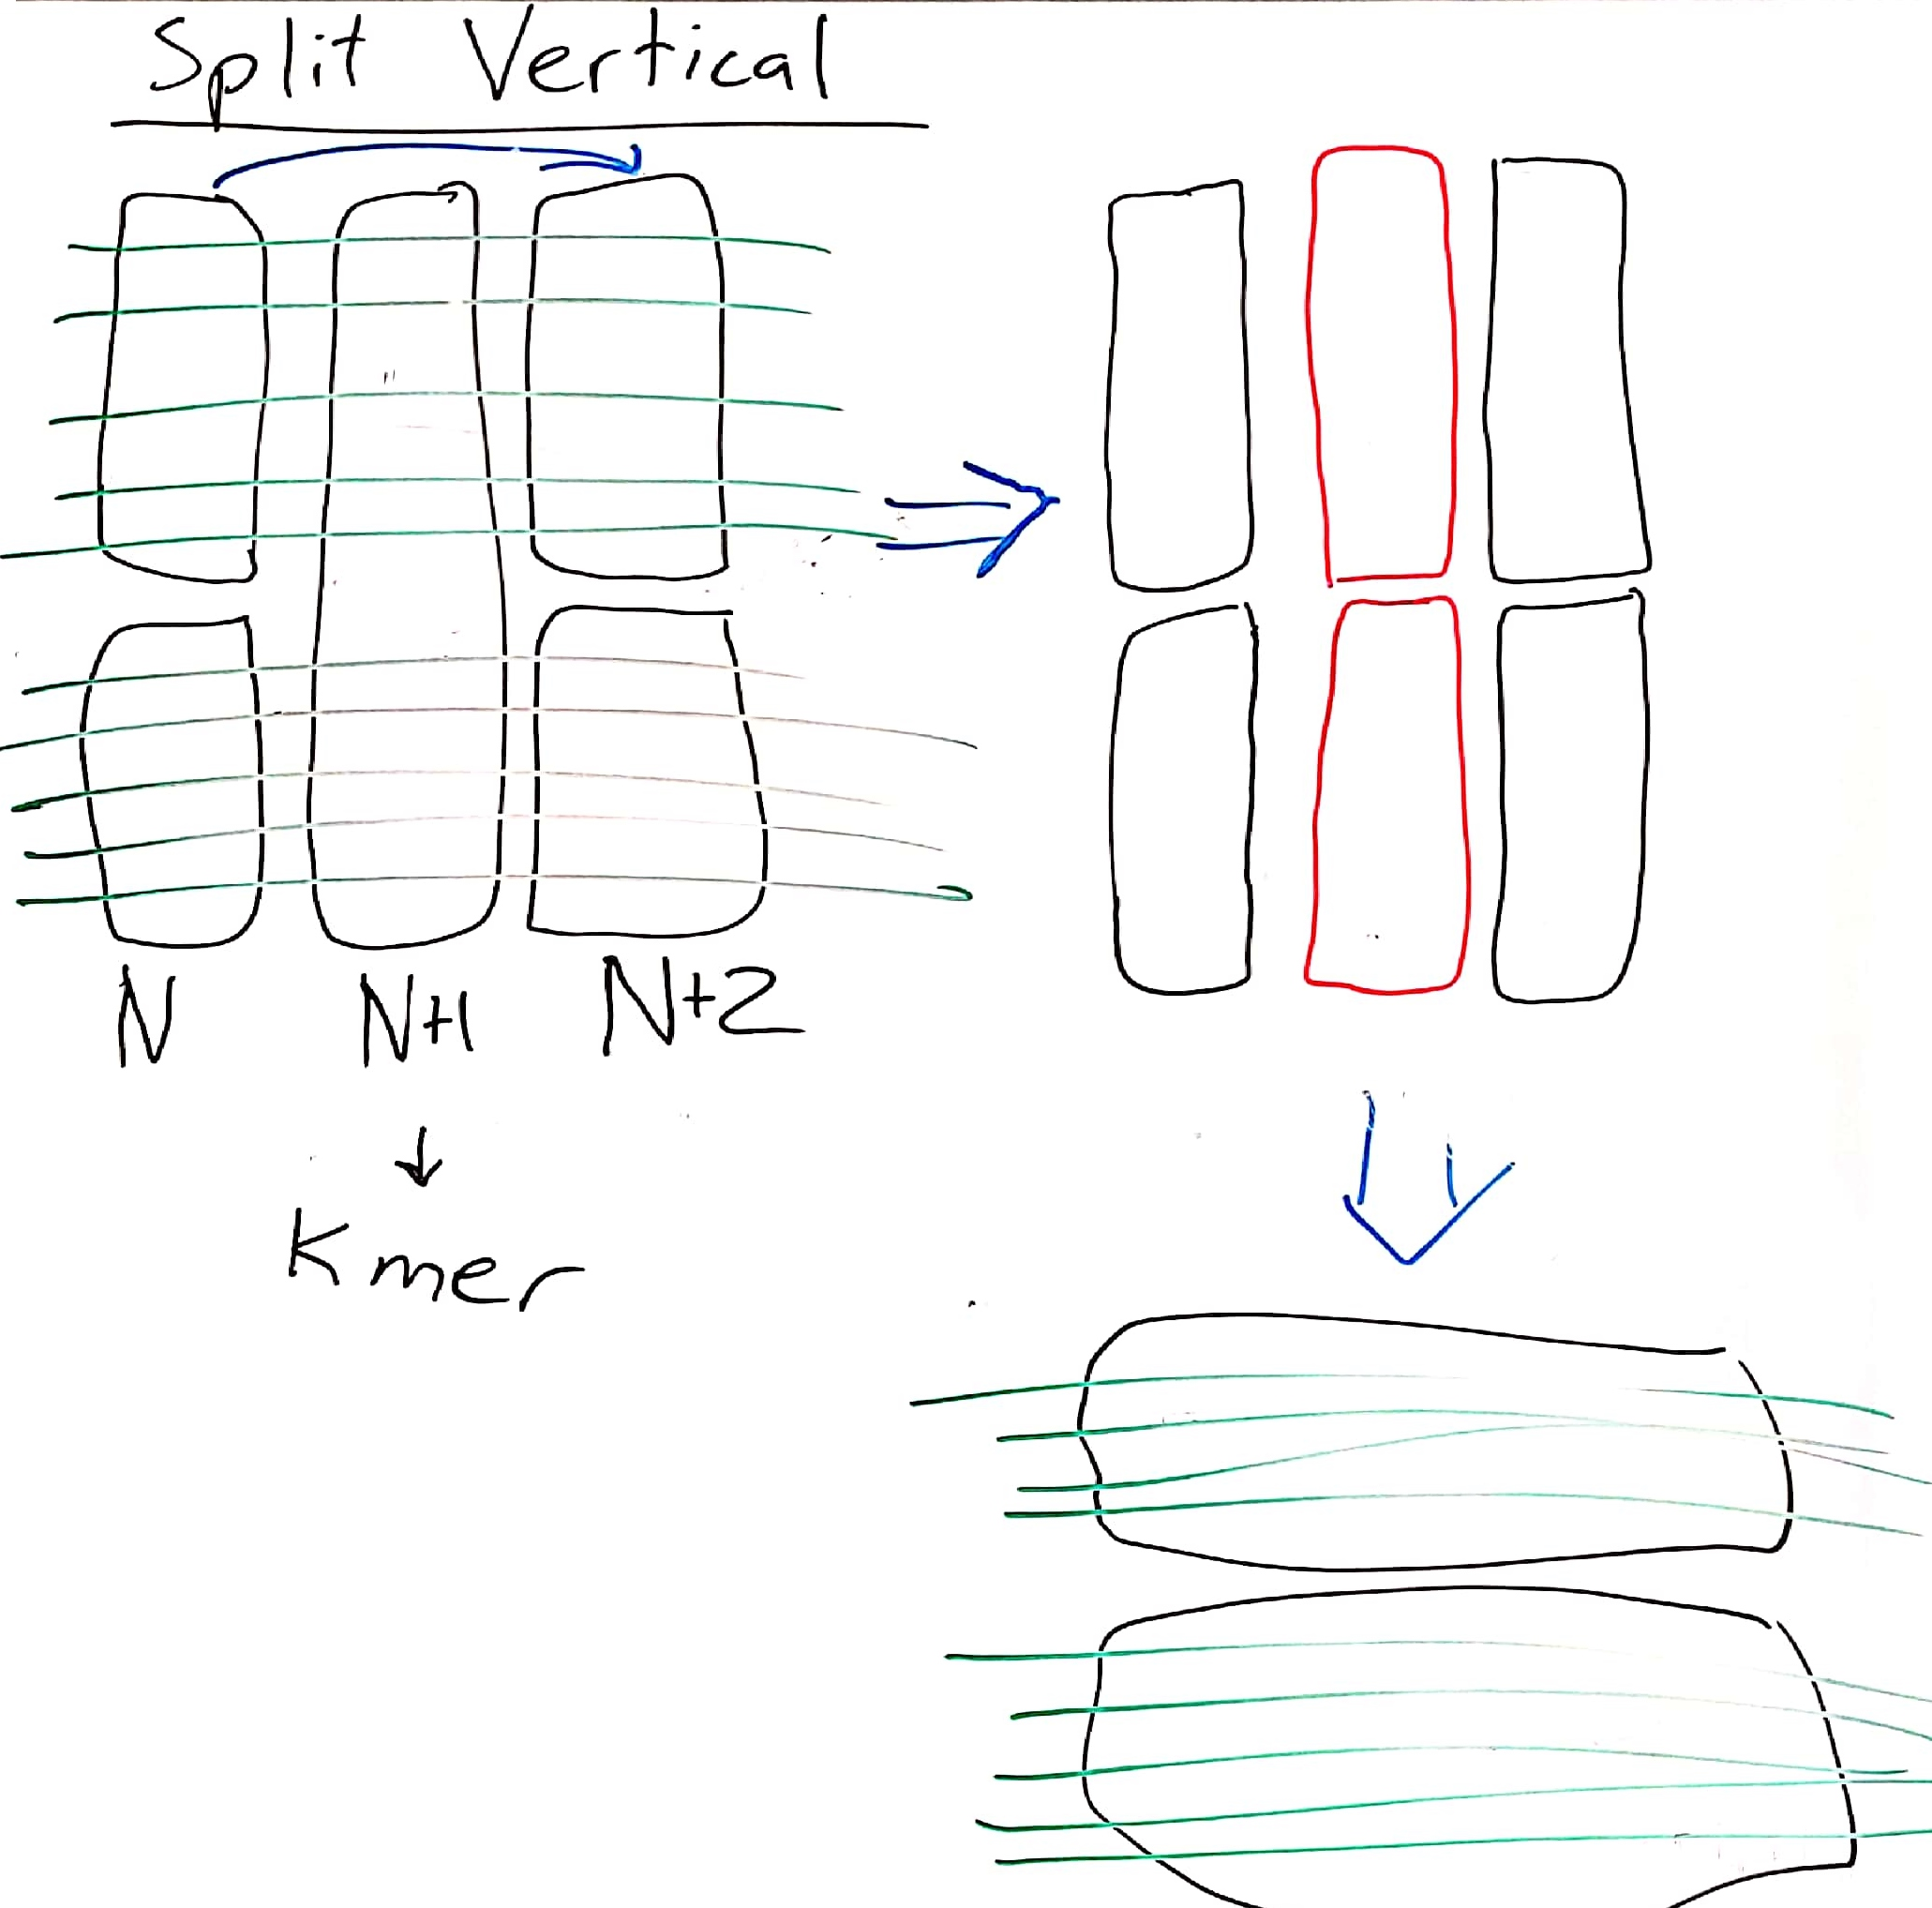

In [ ]:
def split_vertical(N0, anchor, N2):
    """Jumps over anchor nodes and merges 3 slices into one.  Returns new subgraph replacing N0,N1,N2"""
    #TODO: Currently assuming only perfect matches
    #TODO assuming the overlap is in [0]
    commonality = N0[0].intersection(N2[0])
    if not (len(commonality) == len(N0[0]) == len(N2[0])):
        raise ValueError((N0[0], "and", N2[0], "don't match!"))
    else: # Match
        assert len(anchor) == 1, "split_vertical assumes the intervening slice has no alternative nodes"
        # Future TODO allow merging across alternative nodes by finding anchor node, subtracting commonality, 
        # then preserve SNP node -> complex logic for merging sequence in N0 and N2 for third haplotype 
        new_slice = [commonality, anchor[0].difference(commonality)] # replaces three slices
        return [new_slice]
assert split_vertical(base_graph[1], base_graph[2], base_graph[3]) == [[{1, 2, 4}, {3}]]
with test.assertRaises(ValueError): 
    split_vertical(base_graph[2], base_graph[3], base_graph[4]) 

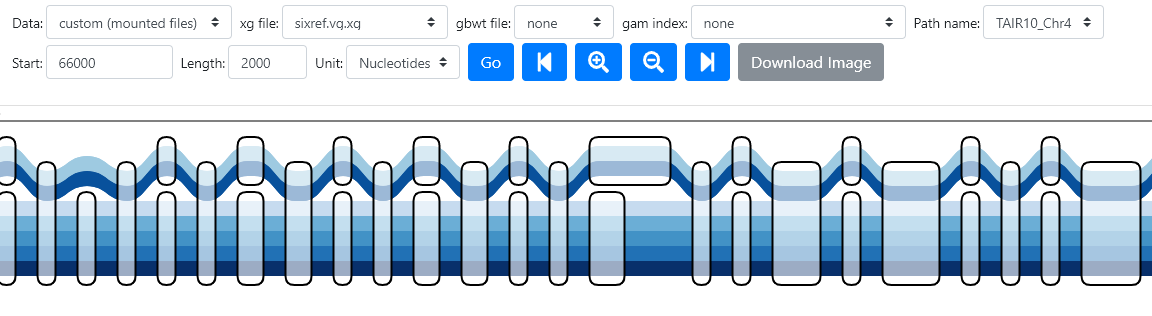
Perfect example of where to use Split Vertical

### Merge Horizontal 
Two adjacent nodes with similar membership are merged into one.  Identity penalty is the difference in path membership * nucleotides in each node.
* Always lossy - IVG "remove redundant nodes" does this on all non-lossy merges. Kmer maximum is the only reason horizontal redundant nodes would still be in the graph.
* Preserves bubbles as haplotype info - Bubbles are the most valuable piece of information.  
* Rounds off the corners of expected variation within one haplotype.  

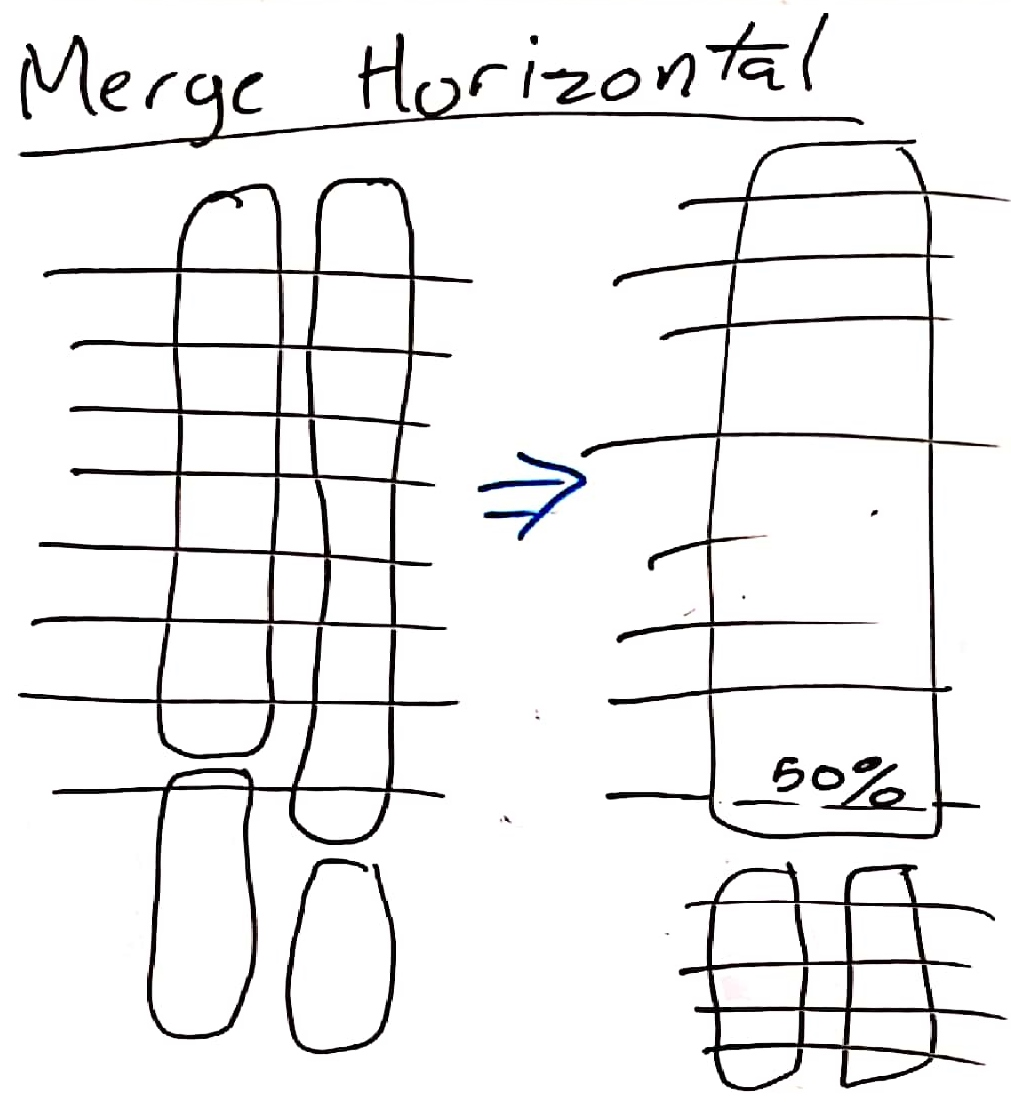

In [ ]:
def merge_horizontal(first_slice, second_slice):
    """Merges two slices into one by lossy rounding of node membership."""
    #TODO: Identify best matching nodes, currently assumes they are in order (this is a bad prototype assumption)  
    #TODO: pick union to be the larger of the two atlernatives, assume majority when summarizing variation.
    if not len(first_slice[0].intersection(second_slice[0])):  # union is only valid if they share something
        raise ValueError(("Intersection of", first_slice[0], "and", second_slice[0], "is empty!"))
        
    commonality = first_slice[0].union(second_slice[0])
    if len(first_slice) > 1 and len(second_slice) > 1:
        alternative_agreement = first_slice[1].union(second_slice[1]).difference(commonality)  # don't include majority
        if alternative_agreement:
            return [[commonality, alternative_agreement]]
    return [[commonality]]
    #TODO: several other possible configurations of third alternatives that need to be considered
    #History: There was a preserve_remainder option that went from 4 nodes to 3 but it was overly complicated, 
    # this became propagate_split()
path_slip = [ [{1,2,3},{4}],  [{1,2},{3,4}], [{1,2,3},{4}] ]
assert merge_horizontal(path_slip[0], path_slip[1]) == [[{1, 2, 3}, {4}]]
assert merge_horizontal(path_slip[1], path_slip[2]) == [[{1, 2, 3}, {4}]]
assert merge_horizontal(base_graph[0], base_graph[1]) == [[{1,2,3,4}]]
with test.assertRaises(ValueError):
    merge_horizontal([{1,2,3}], [{4,5,6}])
#TODO: # single common path gets aggressively merged (not great)
assert merge_horizontal([{1,2,3}], [{3,4,5,6}]) == [[{1, 2, 3, 4, 5, 6}]] 

### Propagate Split
Propagate Split was a moved discovered implementing merge_horizontal() in the case where one slice has all paths in one node.  The difference is the minimum intersection or maximum union of node membership.  Propagate Split is a useful complement to split_vertical() when using a haplotype to cut through neighboring sequence.

In [ ]:
def propagate_split(first_slice, second_slice):
    """When one slice has all paths in one node, and the next slice has the paths split, there are two options.
    You can take the majority and combine all paths into one node, that's what merge_horizontal will do.
    The other path is to use the split slice to split the majority and then merge horizontally, creating
    2 nodes where there was three.  That's what this does."""
    #TODO: Identify best matching nodes, currently assumes they are in order (this is a bad prototype assumption)  
    #TODO: pick union to be the larger of the two atlernatives, assume majority when summarizing variation.
    
    if min(len(first_slice), len(second_slice)) > 1:  # TODO: could guide by slice[0] instead and leave alternatives
        raise ValueError(("At least one slice needs to have no alternatives", first_slice[0], "and", second_slice[0]))
    if max(len(first_slice), len(second_slice)) <= 1: # Need to have a split to work with
        raise ValueError(("No alternative nodes detected", first_slice[0], "and", second_slice[0]))
    split_slice = max((first_slice, second_slice), key=len)
    commonality = first_slice[0].intersection(second_slice[0])
    #preserve ordering
    remainder = split_slice[1].difference(commonality)  #TODO penalize alternative node if not in both slices
    #TODO: guide_slice[1:]  third alternatives etc. iteratively remove commonality
    #TODO: len 1 not all the same: propagate_split(*[[{1, 2, 3}], [{1, 2, 4}]])
    return [[commonality, remainder]]
fracture = [[{1, 2, 3, 4}], [{1, 2, 4}, {3}], [{1, 2, 3, 4}]]
assert propagate_split(*fracture[:2]) == [[{1, 2, 4}, {3}]]
assert propagate_split(*fracture[1:]) == [[{1, 2, 4}, {3}]]
with test.assertRaises(ValueError):
    propagate_split(*[[{1, 2, 4}, {3}], [{1, 2, 4}, {3}]])
with test.assertRaises(ValueError):
    propagate_split(*[[{1, 2, 3}], [{1, 2, 4}]])
propagate_split(*[[{1, 2}, {3},{4}], [{1, 2, 3,4}]])  #Failure case

### End of Core Methods

In [ ]:
def use_merging(graph, merge_fn, start_index):
    """Function that executes a given merge in the context of the whole graph then 
    returns the new graph with merge completed and less slices.  Could use generators for multiple simultaneous merges?"""
    new_graph = graph[:start_index]
    size = {merge_vertical_threesome: 3, # dictionary of functions = number of slices processed
            merge_vertical: 1,
            merge_horizontal: 2,
            propagate_split: 2,
            split_vertical:3} [merge_fn]
    new_graph.extend(merge_fn(*graph[start_index:start_index+size]))
    new_graph.extend(graph[start_index + size:])
    #TODO do more than one merge before building a new summary graph for performance
    return new_graph
base_graph = [ [{1,2,3,4}], [{1,2,4},{3}],  [{1,2,3,4}],  [{1,2,4},{3}],  [{1,2,3},{4}],  [{1,2,3,4}] ]
one = use_merging(base_graph, split_vertical, 1)
assert one == [[{1, 2, 3, 4}], [{1, 2, 4}, {3}], [{1, 2, 3}, {4}], [{1, 2, 3, 4}]]
two = use_merging(one, merge_horizontal, 2)
assert two == [[{1, 2, 3, 4}], [{1, 2, 4}, {3}], [{1, 2, 3, 4}]]
three = use_merging(two, merge_vertical, 1)
assert three == [[{1, 2, 3, 4}], [{1, 2, 3, 4}], [{1, 2, 3, 4}]]  #verifiying intermediate
assert use_merging(two, merge_vertical_threesome, 0) == [[{1, 2, 3, 4}]]

hap3 = use_merging(two, propagate_split, 0)  # Test case where merging into 1 node with no alternatives
assert hap3 == [[{1, 2, 4}, {3}], [{1, 2, 3, 4}]]
hap4 = use_merging(hap3, propagate_split, 0)
hap4

# Automated Graph Generation for testing